In [14]:
import geopandas as gpd
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import pandas as pd

pd.options.mode.copy_on_write = True

In [16]:
def calculate_auto_offset(row):
    """Automatically compute label offsets based on centroid position."""
    lon = row.geometry.centroid.x
    lat = row.geometry.centroid.y

    # Default offsets
    dx, dy = 0, 0

    # If island nations (Caribbean box)
    if -90 < lon < -55 and 0 < lat < 30:
        if lat > 18:  # Bahamas, Antigua etc
            dx, dy = -5, 8
        elif lat > 12:  # Barbados, Dominica, etc
            dx, dy = -5, 5
        else:  # St Lucia, St Vincent, Grenada etc
            dx, dy = -5, -5
    else:
        dx, dy = 0, 0  # mainland countries: no shift

    return dx, dy

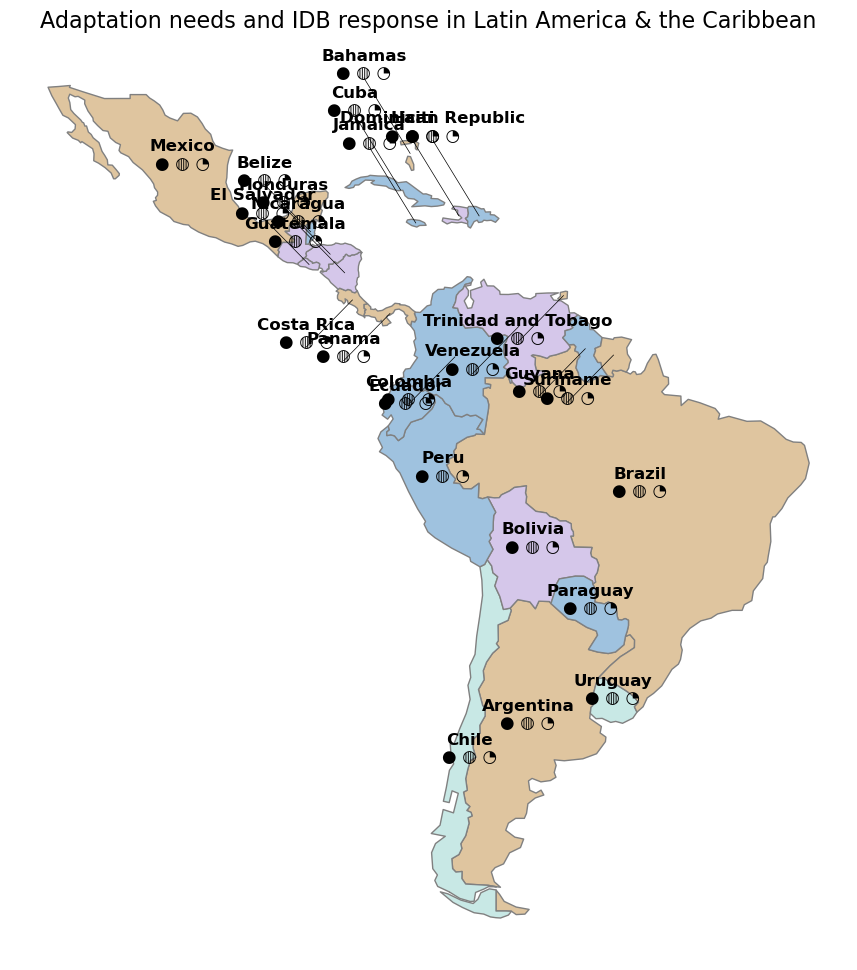

In [19]:

# Use Cartopy to load Natural Earth data (fully programmatic, no manual download)
shapefile_path = shpreader.natural_earth(resolution='110m',
                                         category='cultural',
                                         name='admin_0_countries')

# Read the shapefile with GeoPandas
world = gpd.read_file(shapefile_path)

# Define Latin America & Caribbean ISO3 codes (expanded to include Caribbean islands)
lac_iso = [
    'ARG', 'BLZ', 'BOL', 'BRA', 'CHL', 'COL', 'CRI', 'CUB', 'DOM',
    'ECU', 'SLV', 'GTM', 'GUY', 'HTI', 'HND', 'JAM', 'MEX', 'NIC',
    'PAN', 'PRY', 'PER', 'SUR', 'TTO', 'URY', 'VEN',
    'ATG', 'BRB', 'BHS', 'DMA', 'GRD', 'KNA', 'LCA', 'VCT'
]

# Filter to only LAC countries
lac = world[world['ISO_A3'].isin(lac_iso)]

# Create example resilience need scores (replace with your real data)
resilience_needs = {
    'ARG': 2, 'BLZ': 3, 'BOL': 4, 'BRA': 2, 'CHL': 1, 'COL': 3, 'CRI': 2,
    'CUB': 3, 'DOM': 3, 'ECU': 3, 'SLV': 4, 'GTM': 4, 'GUY': 3, 'HTI': 4,
    'HND': 4, 'JAM': 3, 'MEX': 2, 'NIC': 4, 'PAN': 2, 'PRY': 3, 'PER': 3,
    'SUR': 2, 'TTO': 2, 'URY': 1, 'VEN': 4, 'ATG': 3, 'BRB': 2, 'BHS': 2,
    'DMA': 3, 'GRD': 2, 'KNA': 2, 'LCA': 3, 'VCT': 3
}

# Merge resilience data into GeoDataFrame
lac['resilience'] = lac['ISO_A3'].map(resilience_needs)

# Pastel palette (your previous custom palette)
colors = {
    1: '#c8e8e5',  # Teal (low need)
    2: '#dfc59f',  # Orange (moderate need)
    3: '#9fc2df',  # Blue (high need)
    4: '#d5c7ea'   # Lavender (very high need)
}

# Auto-calculate offsets for small countries
lac['offset'] = lac.apply(calculate_auto_offset, axis=1)

# Plot
fig, ax = plt.subplots(figsize=(14, 12))
lac.plot(ax=ax, color=lac['resilience'].map(colors), edgecolor='gray')

# Example icons per country (replace with real values)
icons = {
    'ARG': '● ◍ ◔', 'BRA': '● ◍ ◔', 'BOL': '● ◍ ◔',
    'MEX': '● ◍ ◔', 'HTI': '● ◍ ◔'
}
# Default icons for all others
default_icons = '● ◍ ◔'

# Annotate country name + icons
for idx, row in lac.iterrows():

    country_name = row['NAME_LONG']
    icon_text = icons.get(row['ISO_A3'], default_icons)
    centroid = row['geometry'].centroid

    dx, dy = row['offset']
    label_x = centroid.x + dx
    label_y = centroid.y + dy

    # Draw leader line
    plt.plot([centroid.x, label_x], [centroid.y, label_y], color='black', linewidth=0.5)

    plt.annotate(
        f"{country_name}\n{icon_text}",
        xy=(label_x, label_y),
        ha='center', fontsize=12, weight='bold'
    )


plt.title("Adaptation needs and IDB response in Latin America & the Caribbean", fontsize=16)
plt.axis('off')
plt.show()
